## Libraries Used

In [44]:
# Data Handling
import pandas as pd
import numpy as np


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.linear_model import LogisticRegression

# Model Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score

# Display Formatting
from IPython.display import display, HTML

## Dataset extraction and organization
### Load and combine all datasets


In [18]:
import os
import pandas as pd

# Ensure data folder exists
os.makedirs("data", exist_ok=True)

# Load datasets
prices_df = pd.read_csv("data/prices-split-adjusted.csv")
securities_df = pd.read_csv("data/securities.csv")

# Display first few rows (optional in scripts, great for notebooks)
prices_df.head(), securities_df.head()

# Filter IT sector companies
it_companies = securities_df[securities_df['GICS Sector'] == 'Information Technology']

# Select 10 companies (including AAPL)
selected_companies = ['AAPL', 'MSFT', 'ORCL', 'IBM', 'INTC', 'CSCO', 'HPQ', 'ADBE', 'NVDA', 'TXN']
print(f"Selected Companies: {', '.join(selected_companies)}")

# Filter prices
filtered_prices = prices_df[prices_df['symbol'].isin(selected_companies)].copy()
filtered_prices['date'] = pd.to_datetime(filtered_prices['date'])
filtered_prices = filtered_prices.sort_values(by=['symbol', 'date'])
filtered_prices = filtered_prices.dropna().drop_duplicates()
filtered_prices = filtered_prices[['date', 'symbol', 'open', 'close', 'volume']]


# Model 1: Only AAPL  model1_data = df[df['symbol'] == 'AAPL']

# model_1_data = filtered_prices[filtered_prices['symbol'] == 'AAPL']
# model_1_data.to_csv("data/model1_data_AAPL.csv", index=False)

# Model 2: All 10 companies
model_2_data = filtered_prices
model_2_data.to_csv("data/model2_data_all_companies.csv", index=False)

# Confirmation
print("Saved model datasets to 'data/' folder")


Selected Companies: AAPL, MSFT, ORCL, IBM, INTC, CSCO, HPQ, ADBE, NVDA, TXN
Saved model datasets to 'data/' folder


## Data Cleaning and Preparation




make the models more flexible. Through some minor changes in preprocessing we can have a model that randomly choose ten companies from a same business area and return the one company model 1 specification and then compare with model 2 as well as we did actually. I think, Jack mentioned a similar idea few days ago. After writing report, if I have extra time I can do it and there is no burden, I think.

In [19]:
# Code here
df = pd.read_csv('data/model2_data_all_companies.csv')
df.head()

,date,symbol,open,close,volume
0,2010-01-04,AAPL,30.490000,30.572857,123432400.0
1,2010-01-05,AAPL,30.657143,30.625713,150476200.0
2,2010-01-06,AAPL,30.625713,30.138571,138040000.0
3,2010-01-07,AAPL,30.250000,30.082857,119282800.0
4,2010-01-08,AAPL,30.042856,30.282858,111902700.0


## Feature Engineering

In [20]:
# Loading the filtered and cleaned data
df = pd.read_csv('data/model2_data_all_companies.csv')

# Converting the date column to datetime format
df['date'] = pd.to_datetime(df['date'])

#Sorting data by company and date( we did it in preprocessing, bbut just to be sure since it is a crucial step)
df= df.sort_values(by=['symbol', 'date'])

# Creating a daily return feature
df['daily_change'] = (df['close'] - df['open']) / df['open'] # measuring the percentage change in the stock price daily for each index

# creating the volum change feature relative to previous day
df['volume_change'] = df.groupby('symbol')['volume'].diff() # Measuring how the volume changed from the previous day.

# Creating a rolling average of the closing price over the past 10 days
df['rolling_close_mean'] = df.groupby('symbol')['close'].transform(lambda x: x.rolling(window=10).mean()) # Each row gets a new value, the 10-day average at that row.

# creaing a rolling average of the volume over the past 10 days
df['rolling_volume_mean'] = df.groupby('symbol')['volume'].transform(lambda x: x.rolling(window=10).mean()) # Each row gets a new value, the 10-day average at that row.

# creating the target variable binary to see the next day's price is higher than today's price or not
df['next_close'] = df.groupby('symbol')['close'].shift(-1) 
df['target'] = (df['next_close'] > df['close']).astype(int) # if row['next_close'] > row['close']: return 1 else: return 0

# Dropping rows with missing values caused by rolling or shifting operations
df = df.dropna() # first 9 rows becuase of roling windows and the last because of shifting operations

# Checking the final result
display(df[['date', 'symbol', 'open', 'close', 'daily_change', 'volume_change', 'rolling_close_mean', 'rolling_volume_mean', 'target']].head())





,date,symbol,open,close,daily_change,volume_change,rolling_close_mean,rolling_volume_mean,target
9,2010-01-15,AAPL,30.132856,29.418571,-0.023705,40293400.0,30.082286,131551980.0,1
10,2010-01-19,AAPL,29.761429,30.719999,0.032208,33985000.0,30.097000,137458930.0,0
11,2010-01-20,AAPL,30.701429,30.247143,-0.014797,-29463700.0,30.059143,137715130.0,0
12,2010-01-21,AAPL,30.297142,29.724285,-0.018908,-999600.0,30.017714,139114990.0,0
13,2010-01-22,AAPL,29.540001,28.250000,-0.043670,68403300.0,29.834429,149230900.0,1


## Exploratory Data Analysis After feature engineering
### Visualizing and analyzing sentiment distribution.

### Distribution Comparison of Closing Prices and Trading Volumes (AAPL vs. IT Sector)

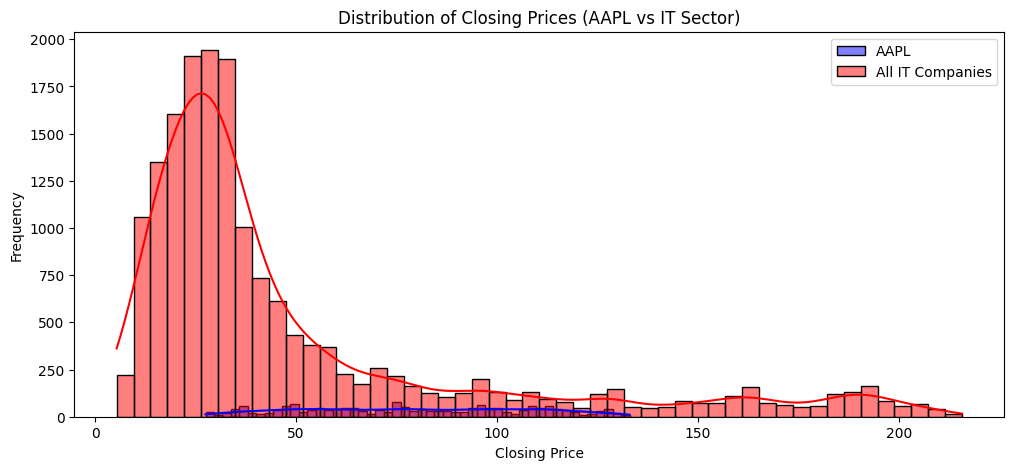

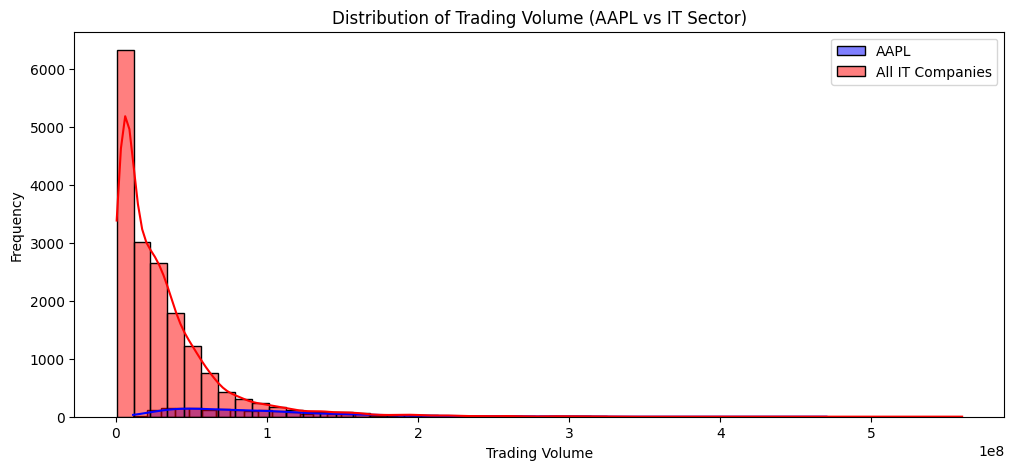

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter Model 1 (AAPL only) and Model 2 (all IT companies)
model_1_data = df[df['symbol'] == 'AAPL']
model_2_data = df  # already contains all 10 companies

# ---- Closing Price Distribution ----
plt.figure(figsize=(12, 5))
sns.histplot(model_1_data['close'], bins=50, label='AAPL', kde=True, color='blue')
sns.histplot(model_2_data['close'], bins=50, label='All IT Companies', kde=True, color='red', alpha=0.5)
plt.xlabel("Closing Price")
plt.ylabel("Frequency")
plt.title("Distribution of Closing Prices (AAPL vs IT Sector)")
plt.legend()
plt.show()

# ---- Trading Volume Distribution ----
plt.figure(figsize=(12, 5))
sns.histplot(model_1_data['volume'], bins=50, label='AAPL', kde=True, color='blue')
sns.histplot(model_2_data['volume'], bins=50, label='All IT Companies', kde=True, color='red', alpha=0.5)
plt.xlabel("Trading Volume")
plt.ylabel("Frequency")
plt.title("Distribution of Trading Volume (AAPL vs IT Sector)")
plt.legend()
plt.show()


### Closing Price Trends Over Time (AAPL vs IT Sector)


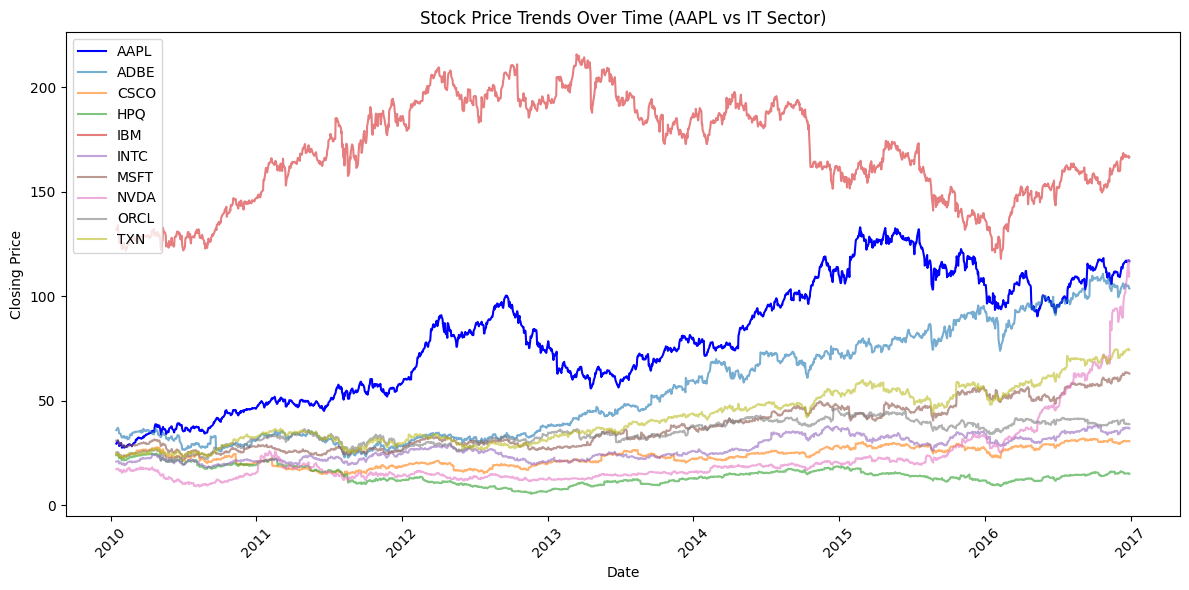

In [22]:
plt.figure(figsize=(12, 6))

# AAPL only
sns.lineplot(data=model_1_data, x='date', y='close', label='AAPL', color='blue')

# All other IT companies (excluding AAPL to avoid duplicate line)
other_companies = model_2_data[model_2_data['symbol'] != 'AAPL']
sns.lineplot(data=other_companies, x='date', y='close', hue='symbol', alpha=0.6)

plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("Stock Price Trends Over Time (AAPL vs IT Sector)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


### Trading Volume Trends Over Time (AAPL vs IT Sector)


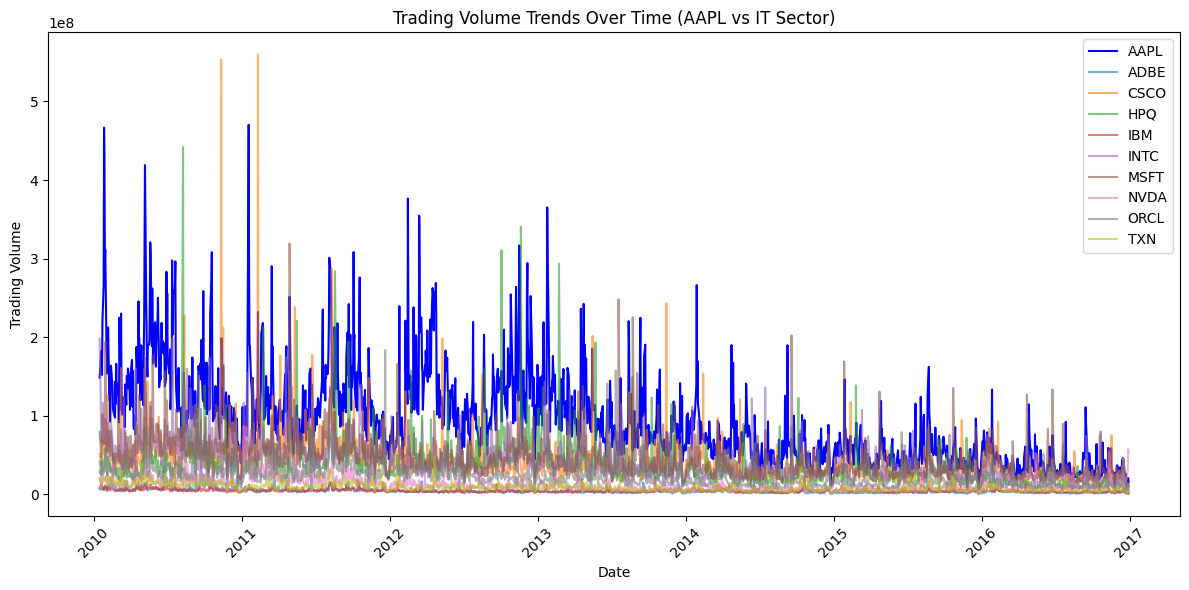

In [23]:
plt.figure(figsize=(12, 6))

# AAPL volume
sns.lineplot(data=model_1_data, x='date', y='volume', label='AAPL', color='blue')

# Volume for other IT companies
sns.lineplot(data=other_companies, x='date', y='volume', hue='symbol', alpha=0.6)

plt.xlabel("Date")
plt.ylabel("Trading Volume")
plt.title("Trading Volume Trends Over Time (AAPL vs IT Sector)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


### Heatmap of Pairwise Correlations Between Stock Closing Prices (IT Sector)

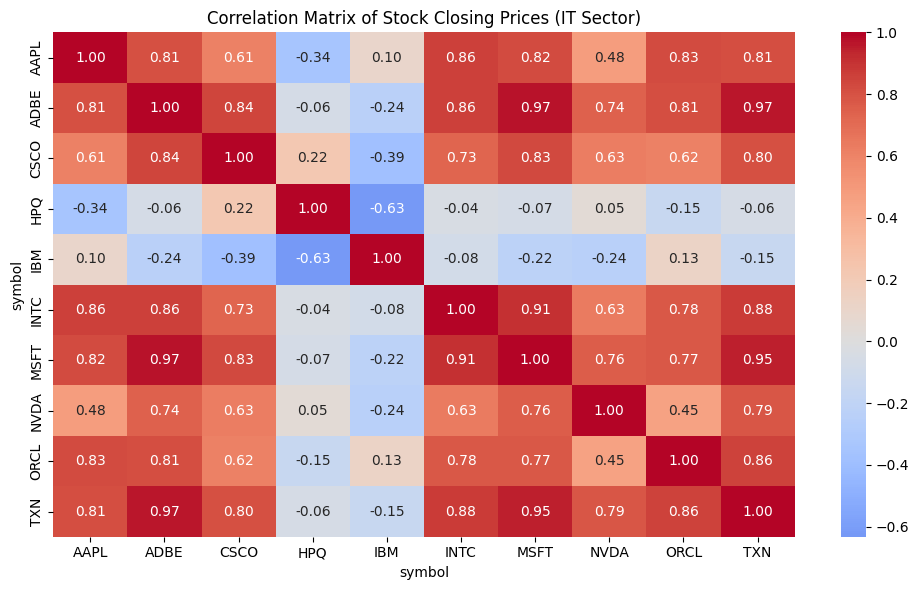

In [24]:
# Pivot the data: each column is one company, rows are dates, values are closing prices
pivot_data = df.pivot(index='date', columns='symbol', values='close')

# Compute correlation matrix between the companies
correlation_matrix = pivot_data.corr()

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation Matrix of Stock Closing Prices (IT Sector)")
plt.tight_layout()
plt.show()

### Target Variable Distribution: Price Increase vs. No Increase


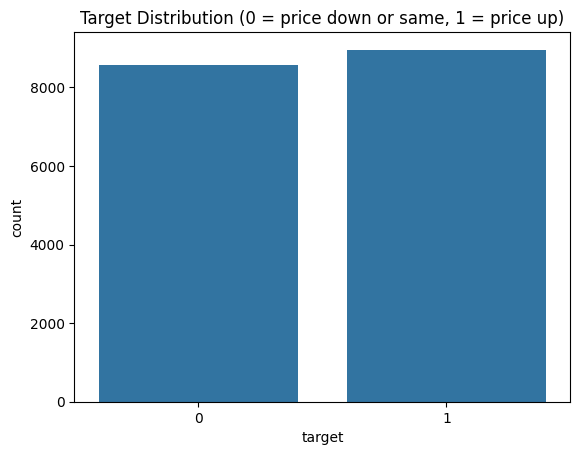

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df, x='target')
plt.title('Target Distribution (0 = price down or same, 1 = price up)')
plt.show()


### Correlation Matrix of Engineered Features and Target Variable


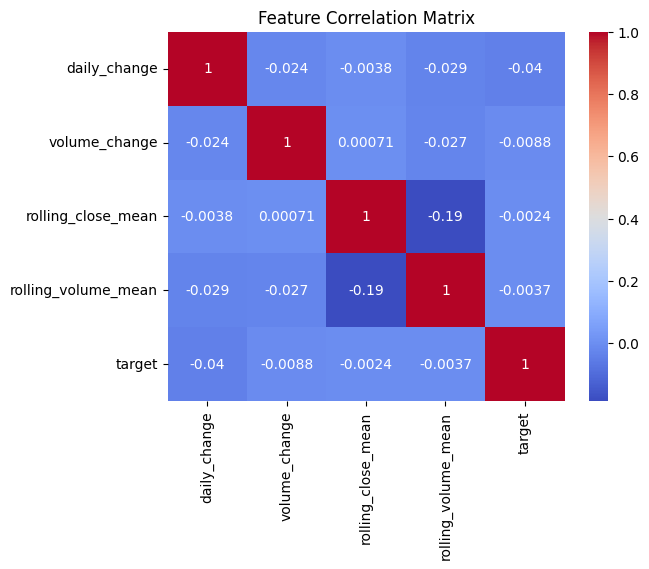

In [26]:
corr = df[['daily_change', 'volume_change', 'rolling_close_mean', 'rolling_volume_mean', 'target']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()


### AAPL Closing Price vs. 10-Day Rolling Average

## Train-Test Split

In [27]:
# from sklearn.model_selection import train_test_split
# We don't use above library Because:
    # this is time series data (stock prices), maintaining chronological order is critical to avoid data leakage.
    # Instead, we manually split the data using iloc to preserve the time-based structure.


# Filteting Model 1 ( AAPL only ) and Model 2 ( AAPL + others )
# using copy method to avoid unintended changes
model_1_data = df[df['symbol'] == 'AAPL'].copy()
model_2_data = df.copy()

#Dropping unnecessary columns 
drop_cols = ['symbol', 'next_close', 'date', 'open', 'close', 'volume'] # these colums are not featyres for our models
model_1_data = model_1_data.drop(columns=drop_cols)
model_2_data = model_2_data.drop(columns=drop_cols)

# Chronologically splitting data into train and test sets( 80% train, 20% test )
# We don't use sklearn's train_test_split because we want to keep the chronological order because it shuffles the data

#Model 1 (APPL Only)
model_1_split_index = int(len(model_1_data) * 0.8) # 80% index for train set
model_1_train = model_1_data.iloc[:model_1_split_index] # 80% of rows for train set
model_1_test = model_1_data.iloc[model_1_split_index:] # 20% of rows for test set

#Model 2 (APPL + Others)
model_2_split_index = int(len(model_2_data) * 0.8) # 80% index for train set
model_2_train = model_2_data.iloc[:model_2_split_index] # 80% of rows for train set
model_2_test = model_2_data.iloc[model_2_split_index:] # 20% of rows for test set

# separating features (x) and target (y)
# The model will learn from features (x) to predict the binary target (y)

# Model 1
x_train_1 = model_1_train.drop(columns='target') # Features input for training (daily_change, volume_change, rolling_close_mean, rolling_volume_mean are independent variables)
y_train_1 = model_1_train['target'] # output for training (dependent variable (0 or 1))
x_test_1 = model_1_test.drop(columns='target')
y_test_1 = model_1_test['target']

# Model 2
x_train_2 = model_2_train.drop(columns='target') # Features input for training (daily_change, volume_change, rolling_close_mean, rolling_volume_mean are independent variables)
y_train_2 = model_2_train['target']
x_test_2 = model_2_test.drop(columns='target')
y_test_2 = model_2_test['target']

# The shapes of eac dataset
print('Model 1 ( AAPL only ):')
print(f'Training set: {x_train_1.shape}, Testing set: {x_test_1.shape}')
print('Model 2 ( AAPL + Others ):')
print(f'Training set: {x_train_2.shape}, Testing set: {x_test_2.shape}')

Model 1 ( AAPL only ):
Training set: (1401, 4), Testing set: (351, 4)
Model 2 ( AAPL + Others ):
Training set: (14016, 4), Testing set: (3504, 4)


## Models Implementation

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Model 1: AAPL only
scaler1 = StandardScaler()
x_train_1_scaled = scaler1.fit_transform(x_train_1)
x_test_1_scaled = scaler1.transform(x_test_1)

clf1 = LogisticRegression(max_iter=1000)
clf1.fit(x_train_1_scaled, y_train_1)
y_prediction_1 = clf1.predict(x_test_1_scaled)

print(accuracy_score(y_test_1, y_prediction_1))
print(classification_report(y_test_1, y_prediction_1))


# Model 2: 10 IT sector companies
scaler2 = StandardScaler()
x_train_2_scaled = scaler2.fit_transform(x_train_2)
x_test_2_scaled = scaler2.transform(x_test_2)

clf2 = LogisticRegression(max_iter=1000)
clf2.fit(x_train_2_scaled, y_train_2)
y_prediction_2 = clf2.predict(x_test_2_scaled)

print(accuracy_score(y_test_2, y_prediction_2))
print(classification_report(y_test_2, y_prediction_2))

0.5783475783475783
              precision    recall  f1-score   support

           0       0.61      0.41      0.49       173
           1       0.56      0.74      0.64       178

    accuracy                           0.58       351
   macro avg       0.59      0.58      0.57       351
weighted avg       0.59      0.58      0.57       351

0.5316780821917808
              precision    recall  f1-score   support

           0       0.54      0.22      0.32      1692
           1       0.53      0.82      0.64      1812

    accuracy                           0.53      3504
   macro avg       0.53      0.52      0.48      3504
weighted avg       0.53      0.53      0.49      3504



## Model Evaluation

In [37]:
from sklearn.metrics import (
    accuracy_score, 
    precision_score,  
    recall_score,     
    f1_score,
    classification_report, 
    confusion_matrix, 
    roc_curve, 
    roc_auc_score
)

def evaluate_model(y_true, y_pred, model_name):
    print(f"====== {model_name} ======")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_true, y_pred):.4f}")
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("\n")

evaluate_model(y_test_1, y_prediction_1, "Model 1 (AAPL Only)")
evaluate_model(y_test_2, y_prediction_2, "Model 2 (AAPL + Others)")

====== Model 1 (AAPL Only) ======
Accuracy: 0.5783
Precision: 0.5641
Recall: 0.7416
F1 Score: 0.6408
Confusion Matrix:
 [[ 71 102]
 [ 46 132]]


====== Model 2 (AAPL + Others) ======
Accuracy: 0.5317
Precision: 0.5306
Recall: 0.8184
F1 Score: 0.6438
Confusion Matrix:
 [[ 380 1312]
 [ 329 1483]]




## Accuracy of both Models in Bar Chart


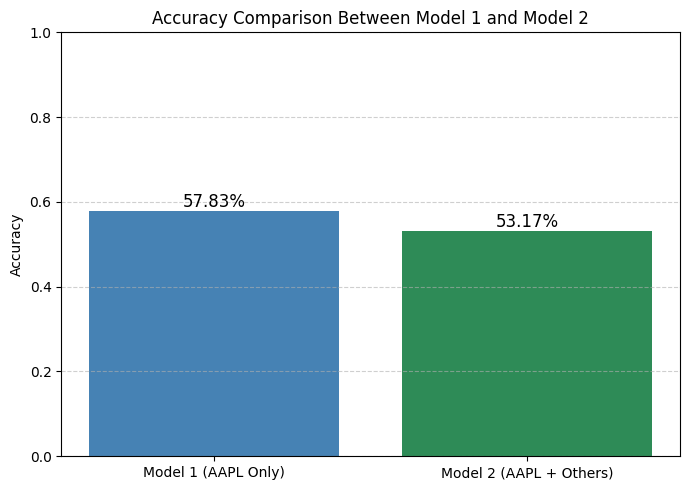

In [40]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Simulated accuracy scores based on previous confusion matrices
accuracy_model1 = accuracy_score(y_test_1, y_prediction_1)  # Changed from y__test_1 to y_test_1
accuracy_model2 = accuracy_score(y_test_2, y_prediction_2)  # Changed from y__test_2 to y_test_2

# Data for the bar plot
model_names = ['Model 1 (AAPL Only)', 'Model 2 (AAPL + Others)']
accuracies = [accuracy_model1, accuracy_model2]

# Create bar chart
plt.figure(figsize=(7, 5))
bars = plt.bar(model_names, accuracies, color=['steelblue', 'seagreen'])

# Add text labels with percentage above each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f"{height:.2%}", ha='center', fontsize=12)

# Set chart details
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison Between Model 1 and Model 2')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()  # This was on the same line as the previous command
plt.show()

## Confusion Matrix of Model 1

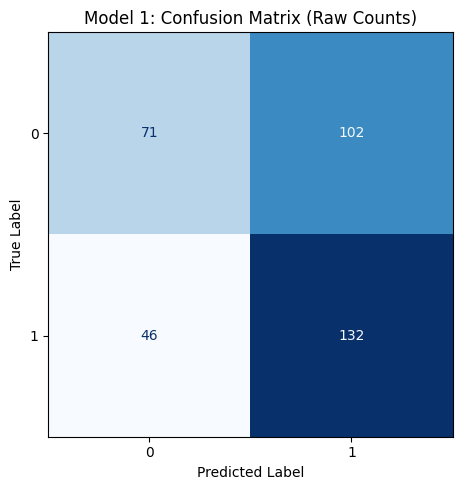

In [42]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Compute raw (not normalized) confusion matrix for Model 1
cm_model1 = confusion_matrix(y_test_1, y_prediction_1)  # Changed from y__test_1

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_model1, display_labels=[0, 1])
disp.plot(ax=ax, cmap='Blues', colorbar=False)

# Add title and labels
ax.set_title('Model 1: Confusion Matrix (Raw Counts)')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
plt.tight_layout()  # This needs to be on a new line
plt.show()

#Conclusion
# print('The model correctly predicted 71 down days but wrongly predicted 102 of them as up.\
#       That''s about 41% accuracy for down days. For up days, the model correctly predicted 132 out of 178 → about 74% accuracy.\
#           Not bad! It still leans toward predicting price will go up, but less aggressively than Model 2.')

## Confusion Matrix Model 2

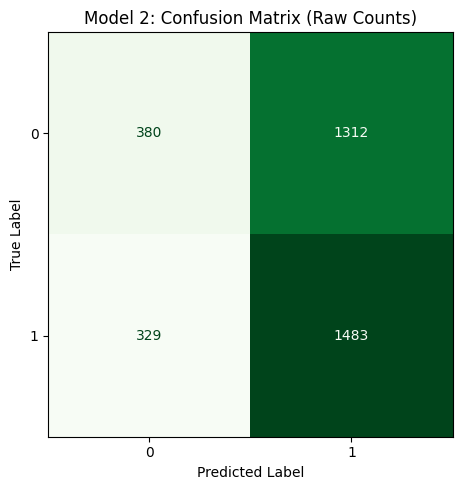

In [43]:
# Compute raw (not normalized) confusion matrix for Model 2
cm_model2 = confusion_matrix(y_test_2, y_prediction_2)  # Changed from y__test_2

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_model2, display_labels=[0, 1])
disp.plot(ax=ax, cmap='Greens', colorbar=False)

# Add title and labels
ax.set_title('Model 2: Confusion Matrix (Raw Counts)')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
plt.tight_layout()
plt.show()

#Conclusion
# print('When the stock actually went down, the model was wrong most of the time — 
#       it predicted "up" instead. Only 380 correct out of 1,692 → that\'s about 22% accuracy for down days.
#           When the stock actually went up, the model did pretty well. It got 1483 out of 1812 correct → about 82% accuracy for up days.')